In [ ]:
# Improvments that can be done
# 1. Use bigger model. Try models from https://tfhub.dev/google/collections/bert/1

# 2. Use multiple bert model and perform ensemble learning.

# 3. Gather more data.

# 4. Use methods like handcrafted features, drop, interactions and projections 
# cited in the paper https://aclanthology.org/W19-3815.pdf

# 5. Chunk in terms of size rather than sentences to input bigger text, so that as much context as possible is 
# passed through bert to get more accurate contextual embeddings. 

In [2]:
!pip install --quiet tensorflow-text
!pip install --quiet bert-tensorflow
!pip install --quiet transformers

In [6]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
import numpy as np # linear algebra
import pandas as pd
import re
from transformers import TFBertModel, BertTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from wordcloud import WordCloud


# Define the model
#BERT_MODEL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
BERT_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
 
# Choose the preprocessing that must match the model
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

preprocess = hub.load(PREPROCESS_MODEL)

bert = hub.load(BERT_MODEL)
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [1]:
BATCH_SIZE = 64
LAYER = 9
SEQ_LENGTH = 256
EPOCHS = 100
N_FOLD = 5
generate_dataset = True

In [2]:
#helper functions to find the char count and offsets
def compute_offset_no_spaces(text, offset):
	count = 0
	for pos in range(offset):
		if text[pos] != " ": count +=1
	return count

def count_chars_no_special(text):
	count = 0
	special_char_list = ["#"]
	for pos in range(len(text)):
		if text[pos] not in special_char_list: count +=1
	return count

def count_length_no_special(text):
	count = 0
	special_char_list = ["#", " "]
	for pos in range(len(text)):
		if text[pos] not in special_char_list: count +=1
	return count

In [3]:
#function that takes in text and returns the BERT output of layer n
def get_text_emb_bert(text, seq_length, layer=-1):
  sentences = text.split(". ")
  #preprocessing API
  #inputs = preprocess(sentences)

  #custom preprocessing
  tokenized_sentences = tokenizer.batch_encode_plus(sentences, max_length=seq_length, padding='max_length', truncation=True)
  # Convert the token IDs to a TensorFlow tensor
  inputs_tokens = tf.constant(tokenized_sentences['input_ids'])
  token_type_ids = tf.constant(tokenized_sentences['token_type_ids'])
  attention_mask = tf.constant(tokenized_sentences['attention_mask'])
  inputs = {
    'input_word_ids': inputs_tokens,
    'input_type_ids': token_type_ids,
    'input_mask': attention_mask
  }
  outputs = bert(inputs)
  if layer==-1:
    return outputs['sequence_output']
  else:
    try:
      return outputs['encoder_outputs'][(layer-1)]
    except Exception as e:
      print(f"There's no layer {layer} in {BERT_MODEL}")

In [4]:
#function to find the location of the word in a sentence in the text.
def get_location(word, word_offset, text):
  pattern = re.compile(r'\.(?=[^ ])')
  removed_count = text[:word_offset].count(r'\.(?=[^ ])')
  text = pattern.sub('', text)

  sentences = text.split(". ")
  sentence_id,count, word_id, sentence_wos_offset,temp_count= 0,0,0,0,0
  word_offset_wos = compute_offset_no_spaces(text, word_offset) - removed_count
  
  text_wos = text.replace(" ","")
  
  for i in range(word_offset_wos):
    temp_count +=1
    if text_wos[i]==".":
      sentence_id+=1
      sentence_wos_offset=temp_count
  
  tokens = tokenizer.tokenize(sentences[sentence_id])
  
  for t, token in enumerate(tokens):
    count+=count_chars_no_special(token)
    if count>(word_offset_wos - sentence_wos_offset):
      word_id = t
      break 
  return sentence_id, word_id

In [7]:
#for testing
temp = pd.read_csv("/kaggle/input/gap-dataset/gap-development.csv")
text_sample = r"Upon their acceptance into the Kontinental Hockey League, Dehner left Finland to sign a contract in Germany with EHC M*nchen of the DEL on June 18, 2014. After capturing the German championship with the M*nchen team in 2016, he left the club and was picked up by fellow DEL side EHC Wolfsburg in July 2016. Former NHLer Gary Suter and Olympic-medalist Bob Suter are Dehner's uncles. His cousin is Minnesota Wild's alternate captain Ryan Suter."
text_sample2 = r"Her Santa.Fe Opera debut in 2005 was as Nuria in the revised edition of Golijov's Ainadamar. She sang on the subsequent Deutsche Grammophon recording of the opera. For his opera Doctor Atomic, Adams rewrote the role of Kitty Oppenheimer, originally a mezzo-soprano role, for soprano voice, and Rivera sang the rewritten part of Kitty Oppenheimer at Lyric Opera of Chicago, De Nederlandse Opera, and the Metropolitan Opera., all in 2007. She has since sung several parts and roles in John Adams' works, including the soprano part in El Ni*o, and the role of Kumudha in A Flowering Tree in the Peter Sellars production at the New Crowned Hope Festival in Vienna."

In [8]:
#function that gives the contextual embeddings of the words passed in a text
def get_contextual_word_emb(words, word_offsets, text):
  '''
  Returns the contextual embedding of A, B, and the Pronoun 
  from the BERT final layer.
  '''
  split_emb = np.empty((0, 768))
  
  text_embedding = get_text_emb_bert(text, SEQ_LENGTH, layer=LAYER)
  for i,(word, word_offset) in enumerate(zip(words, word_offsets)):
    sentence_id, word_id = get_location(word, word_offset, text)
    # split_emb.iloc[0,i] = tf.reshape(text_embedding[sentence_id,word_id,:], [1,768])
    emb = np.array(text_embedding[sentence_id,word_id,:])
    emb = emb.reshape((1,768))
    split_emb = np.concatenate([split_emb, emb], axis=0)

  return split_emb

In [9]:
#test
sample = 5
print(temp.loc[sample,'ID'])
get_contextual_word_emb([temp.loc[sample,'A'],temp.loc[sample,'B'],temp.loc[sample,'Pronoun']],[temp.loc[sample,'A-offset'],temp.loc[sample,'B-offset'],temp.loc[sample,'Pronoun-offset']],temp.loc[5,'Text'])


development-6


array([[-0.04653267, -0.81456673, -0.73986316, ...,  0.00242346,
         0.45023853,  0.01962868],
       [-0.20800383, -1.18223238, -0.21347037, ..., -0.41529518,
         0.12317621,  0.15626319],
       [-0.24603209, -0.75782895, -0.7105177 , ...,  0.30961904,
         0.30452204,  0.22721307]])

In [10]:
#function to generate embeddings for the entire dataset at once
def get_emb_set(df):
  x = np.empty((0, 3, 768))
  y = []
  for i in tqdm(range(len(df))):
    try:
      #print("Index:",i)
      words = [df.loc[i,'A'],df.loc[i,'B'],df.loc[i,'Pronoun']]
      offsets = [df.loc[i,'A-offset'],df.loc[i,'B-offset'],df.loc[i,'Pronoun-offset']]
      text = df.loc[i,'Text']
      label = "Neither"
      if (df.loc[i,"A-coref"] == True):
        label = "A"
      if (df.loc[i,"B-coref"] == True):
        label = "B"
      temp = get_contextual_word_emb(words,offsets,text)
      y.append(label)
      x=np.concatenate([x,temp[np.newaxis, ...]],axis=0)
    except Exception as e:
      print(f"Error on {df.loc[i,'ID']}: {e}")
      continue
  return x, np.array(y)

In [11]:
gap_dev = pd.read_csv("/kaggle/input/gap-dataset/gap-development.csv")
gap_val = pd.read_csv("/kaggle/input/gap-dataset/gap-validation.csv")
gap_test = pd.read_csv("/kaggle/input/gap-dataset/gap-test.csv")

In [12]:
gap_dev.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [13]:
if generate_dataset:
    train_X,train_Y = get_emb_set(gap_dev)
    val_X, val_Y = get_emb_set(gap_val)
    test_X, test_Y = get_emb_set(gap_test)

100%|██████████| 2000/2000 [01:40<00:00, 19.98it/s]


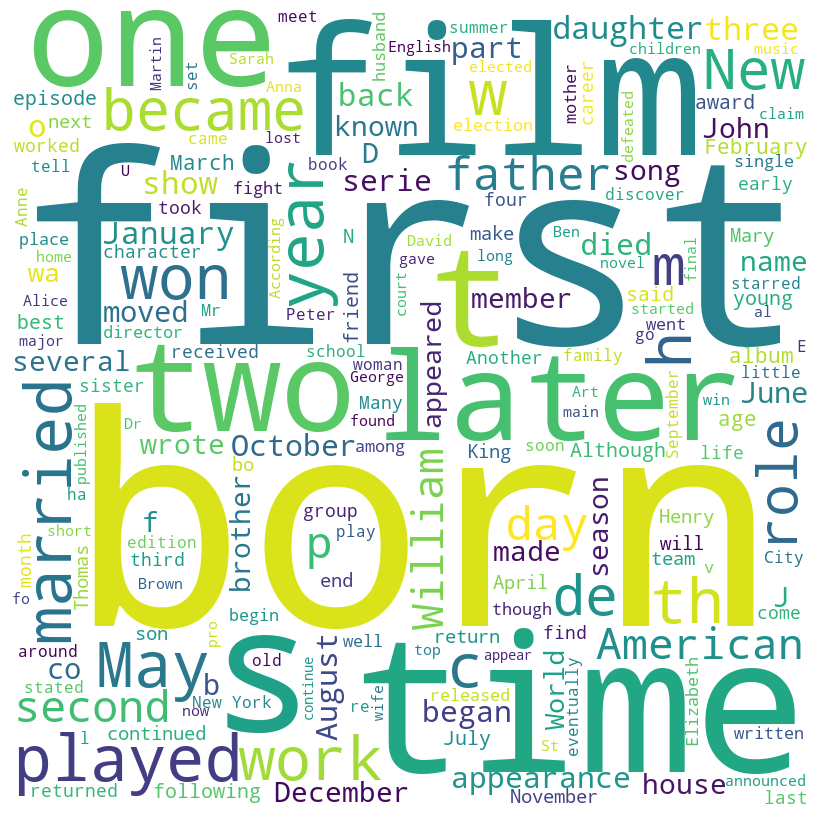

In [14]:
full_text_dev = gap_dev['Text'].to_string(index=False)
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(full_text_dev)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [15]:
np.save('X_train.npy', train_X)
np.save('Y_train.npy', train_Y)

np.save('X_val.npy', val_X)
np.save('Y_val.npy', val_Y)

np.save('X_test.npy', test_X)
np.save('Y_test.npy', test_Y)

In [16]:
le = LabelEncoder()

# fit the encoder to the labels and transform the labels
train_Y = le.fit_transform(train_Y)
val_Y = le.fit_transform(val_Y)
test_Y = le.fit_transform(test_Y)

In [18]:
#test function. Not used.
def text_to_emb(input_text):
  sentences = input_text.split(". ")

  # Tokenize each sentence and add special tokens
  tokenized_sentences = tokenizer.batch_encode_plus(sentences, max_length=256, padding='max_length', truncation=True)
  # Convert the token IDs to a TensorFlow tensor
  inputs_tokens = tf.constant(tokenized_sentences['input_ids'])
  token_type_ids = tf.constant(tokenized_sentences['token_type_ids'])
  attention_mask = tf.constant(tokenized_sentences['attention_mask'])
  inputs = {
    'input_word_ids': inputs_tokens,
    'input_type_ids': token_type_ids,
    'input_mask': attention_mask
  }
  # inputs = preprocess(sentences)
  #print(inputs)
  tokens = tokenizer.tokenize(sentences[2])
  #print(tokens)
  outputs = bert(inputs)
  return outputs


In [15]:
output = text_to_emb(text_sample2)


['in', 'phoenix', ',', 'arizona', 'and', 'into', 'reside', '##ncies', 'in', 'los', 'angeles', ',', 'and', 'eventually', 'moved', 'towards', 'trance']


In [16]:
output['encoder_outputs'][8].shape

TensorShape([6, 256, 768])

#### Model

In [19]:
#model architecture
def get_model():
  # Add dense layers
  input = tf.keras.layers.Input(shape=(3, 768))
  x = tf.keras.layers.Dropout(0.4)(input)
  x = tf.keras.layers.Dense(2048)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(1024)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)

  # Output layer
  x = tf.keras.layers.Flatten()(x)
  output = tf.keras.layers.Dense(3, activation='softmax')(x)

  # Define the model
  model = tf.keras.models.Model(input, outputs=output)

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
      metrics=[
          "accuracy"
      ]
  )
  return model

# Create the model
#model = get_model()
#model.summary()


Epoch 1/50
32/32 [==============================] - 5s 22ms/step - loss: 0.8805 - accuracy: 0.6320 - val_loss: 0.9064 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.6322 - accuracy: 0.7250 - val_loss: 0.7692 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 0.5467 - accuracy: 0.7765 - val_loss: 0.6605 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.4855 - accuracy: 0.8050 - val_loss: 0.7080 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.4492 - accuracy: 0.8120 - val_loss: 0.7118 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.3883 - accuracy: 0.8365 - val_loss: 0.7457 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 0s 13ms/step - loss: 0.346

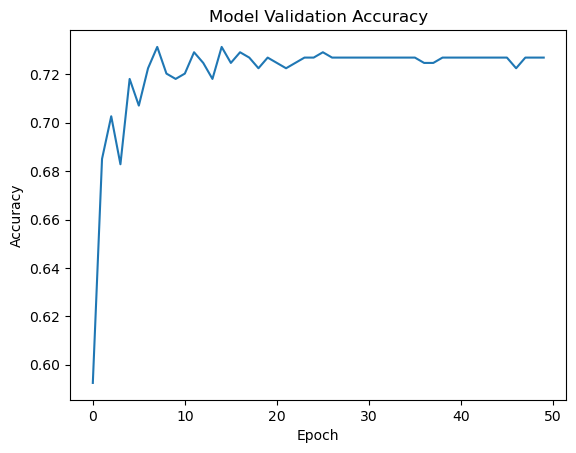

In [20]:
#model training
model = get_model()
callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.3,
                                             patience=5, verbose=0),
        tf.keras.callbacks.ModelCheckpoint(f"model_fc_1.h5", save_best_only=True, 
                                           restore_best_weights=True, monitor="val_accuracy", 
                                           mode="max")]
history = model.fit(train_X, train_Y,
                    validation_data=(val_X, val_Y),
                    epochs=EPOCHS-50,
                    batch_size=BATCH_SIZE,
                    callbacks = callbacks
)

print('Test accuracy:', model.evaluate(test_X, test_Y)[1]*100)

# Plot the validation accuracy with epochs
plt.plot(history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


Fold 0
Epoch 1/50
25/25 [==============================] - 3s 25ms/step - loss: 0.9153 - accuracy: 0.6150 - val_loss: 0.8718 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 13ms/step - loss: 0.6502 - accuracy: 0.7131 - val_loss: 0.7205 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.5252 - accuracy: 0.7862 - val_loss: 0.7147 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4591 - accuracy: 0.8119 - val_loss: 0.7706 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 13ms/step - loss: 0.3753 - accuracy: 0.8425 - val_loss: 0.8170 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.8600 - val_loss: 0.8126 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 13ms/step - loss

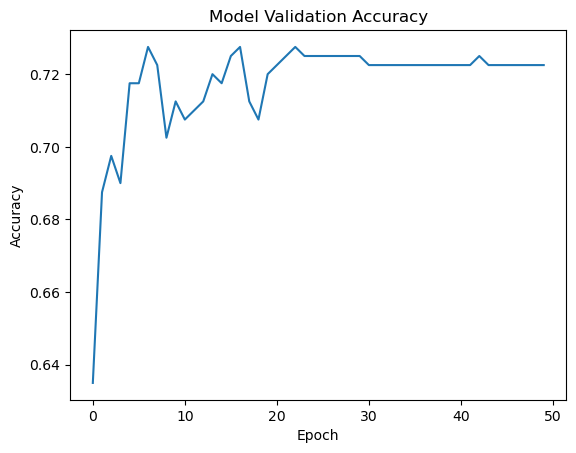

Fold 1
Epoch 1/50
25/25 [==============================] - 3s 25ms/step - loss: 0.9336 - accuracy: 0.6100 - val_loss: 0.7114 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 12ms/step - loss: 0.6779 - accuracy: 0.7262 - val_loss: 0.6830 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 13ms/step - loss: 0.5429 - accuracy: 0.7750 - val_loss: 0.5951 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.8025 - val_loss: 0.6778 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.3962 - accuracy: 0.8444 - val_loss: 0.6481 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.3259 - accuracy: 0.8731 - val_loss: 0.7139 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 

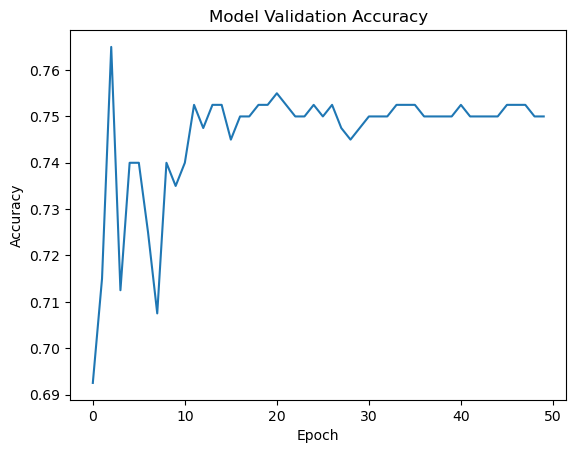

Fold 2
Epoch 1/50
25/25 [==============================] - 3s 24ms/step - loss: 0.9850 - accuracy: 0.5969 - val_loss: 0.7483 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6419 - accuracy: 0.7194 - val_loss: 0.6798 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 13ms/step - loss: 0.5439 - accuracy: 0.7663 - val_loss: 0.6595 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4819 - accuracy: 0.7981 - val_loss: 0.6852 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4341 - accuracy: 0.8125 - val_loss: 0.6841 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8619 - val_loss: 0.7056 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0

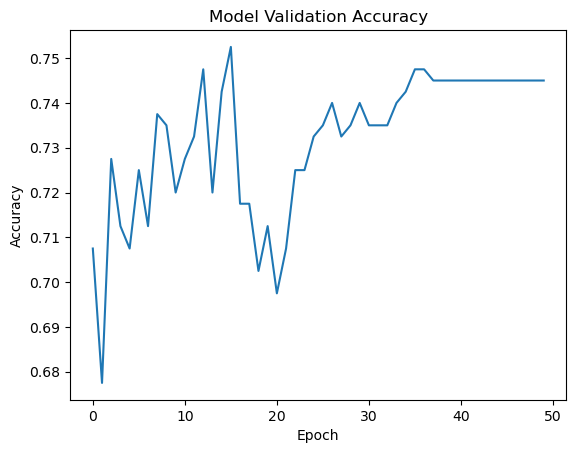

Fold 3
Epoch 1/50
25/25 [==============================] - 3s 24ms/step - loss: 0.9441 - accuracy: 0.6069 - val_loss: 0.7811 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6480 - accuracy: 0.7237 - val_loss: 0.7937 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 13ms/step - loss: 0.5169 - accuracy: 0.7937 - val_loss: 0.7315 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 13ms/step - loss: 0.4392 - accuracy: 0.8169 - val_loss: 0.7101 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 13ms/step - loss: 0.3872 - accuracy: 0.8494 - val_loss: 0.7474 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.3086 - accuracy: 0.8756 - val_loss: 0.8435 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 8ms/step - loss:

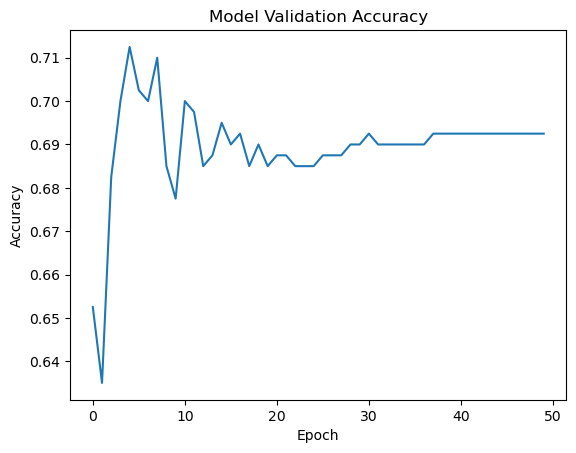

Fold 4
Epoch 1/50
25/25 [==============================] - 3s 25ms/step - loss: 0.9491 - accuracy: 0.6169 - val_loss: 0.8953 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 14ms/step - loss: 0.6432 - accuracy: 0.7331 - val_loss: 0.7150 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.5377 - accuracy: 0.7713 - val_loss: 0.6794 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 13ms/step - loss: 0.4570 - accuracy: 0.8138 - val_loss: 0.6782 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 13ms/step - loss: 0.4143 - accuracy: 0.8338 - val_loss: 0.6639 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.3729 - accuracy: 0.8500 - val_loss: 0.6967 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 8ms/step - loss

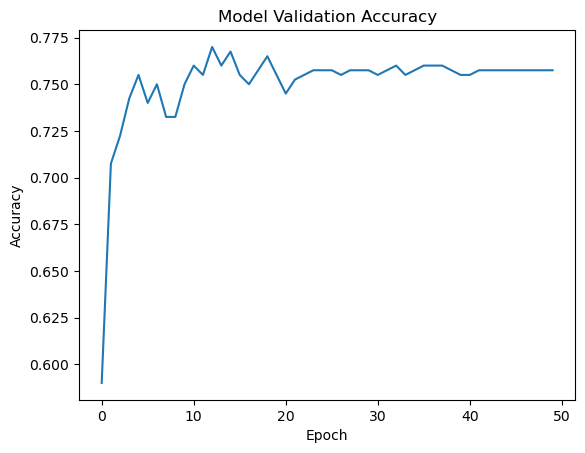

In [51]:
# Train the model - Cross validation
# folds = KFold(n_splits=N_FOLD, shuffle=True, random_state=3)
# for fold_n, (train_index, valid_index) in enumerate(folds.split(train_X)):
#     # split training and validation data
#     print('Fold', fold_n)
#     X_tr, X_val = train_X[train_index], train_X[valid_index]
#     Y_tr, Y_val = train_Y[train_index], train_Y[valid_index]
#     model = get_model()
#     callbacks = [
#             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.3,
#                                                  patience=5, verbose=0),
#             tf.keras.callbacks.ModelCheckpoint(f"model_fc_1_CV{fold_n}.h5", save_best_only=True, 
#                                                restore_best_weights=True, monitor="val_accuracy", 
#                                                mode="max")]
#     history = model.fit(X_tr, Y_tr,
#                         validation_data=(X_val, Y_val),
#                         epochs=EPOCHS-50,
#                         batch_size=BATCH_SIZE,
#                         callbacks = callbacks
#     )
#     model = tf.keras.models.load_model(f"/kaggle/working/model_fc_1_CV{fold_n}.h5")
#     print(f'Fold {fold_n}', model.evaluate(test_X, test_Y))

#     # Plot the validation accuracy with epochs
#     plt.plot(history.history['val_accuracy'])
#     plt.title('Model Validation Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.show()


In [77]:
from scipy.stats import mode

In [101]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [21]:
# # Load the models and make predictions on the test data
# models = []
# for i in range(N_FOLD):
#     model = tf.keras.models.load_model(f"model_fc_1_CV{i}.h5")
#     models.append(model)
 
# predictions = []
# ensemble_pred = []

# for i in tqdm(range(len(test_X))):
#     for model in models:
#         pred = model.predict(tf.reshape(test_X[i], (-1, 3, 768)), verbose=0)
#         predictions.append(np.argmax(pred, axis=1)[0])
#     ensemble_pred.append(mode(predictions))


# pred_final = []
# for i in range(len(ensemble_pred)):
#     pred_final.append(ensemble_pred[i][0][0])

# print(accuracy(list(test_Y), pred_final))


In [26]:
#final results
model = tf.keras.models.load_model("/kaggle/working/model_fc_1.h5")
print(f"The test accuracy of the final model is {round(model.evaluate(test_X, test_Y)[1]*100,2)}%")


63/63 [==============================] - 1s 6ms/step - loss: 0.8380 - accuracy: 0.7465
The test accuracy of the final model is 74.65%
